In [199]:
import numpy as np
from scipy import stats
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
%matplotlib inline
# %matplotlib notebook (zoom)
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy.stats import norm
from sympy import Symbol, symbols, Matrix, sin, cos
from sympy import init_printing
from sympy.utilities.codegen import codegen
init_printing(use_latex=True)

# Extended Kalman Filter Implementation for Constant Turn Rate and Acceleration (CTRA) Vehicle Model in Python

**Kalman Filter** works with linear systems.

**Extended Kalman Filter (EKF)** uses a more general nonlinear set of equations:

$\boldsymbol{x}_{k} = f(\boldsymbol{x}_{k-1}, \boldsymbol{u}_{k-1}) + \boldsymbol{w}_{k-1}$

$\boldsymbol{y}_{k} = h(\boldsymbol{x}_{k}) + \boldsymbol{v}_{k}$

Where $w_k$ and $v_k$ are the process and observation noises which are both assumed to be zero mean Multivariate Gaussian noises with covariance matrix $Q$ and $R$ respectively.

The function $f$ can be used to compute the predicted state from the previous estimate and similarly the function $h$ can be used to compute the predicted measurement from the predicted state. However, $f$ and $h$ cannot be applied to the covariance directly. Instead a matrix of partial derivatives (the **Jacobian matrix**) is computed.

At each time step, the Jacobian is evaluated with current predicted states. This process essentially linearizes the non-linear function around the current estimate.

[Wikipedia](http://en.wikipedia.org/wiki/Extended_Kalman_filter): In the Extended Kalman filter, the state transition and observation models need not be linear functions of the state but may instead be differentiable functions.

![Extended Kalman Filter Step](ExtendedKalmanFilterAlgorithm.png)

## ISO 8855 Reference Frames

**World frame** is the earth-fixed system (or ENU: East North Up).

![](ENU.png)

**Body frame** is attached to the vehicle and rotates with it in all three axes with the yaw, pitch and roll of the vehicle.
* The X axis is parallel to the vehicle’s heading and is in the forward direction of the vehicle.
* The Y axis is perpendicular to the X axis and is in the left direction of the vehicle.
* The Z axis is perpendicular to the X and Y axes and is in the up direction of the vehicle.

![](RPY_angles_of_cars.png)


**Yaw (Heading)**
* This angle is between the forward direction of the vehicle, projected in to the horizontal plane, and the East. 
* Positive rotation is from the East and counter-clockwise when looking from above, about the up direction axis of the vehicle.

**Pitch** 
* This angle is obtained with a rotation about the lateral direction axis of the vehicle. 
* Positive rotation is from horizontal and clockwise when looking in the same direction of the lateral axis.

**Roll**
* This angle is obtained with a rotation about the forward direction axis of the vehicle. 
* Positive rotation is from horizontal and clockwise when looking from behind.


## State Vector - Constant Turn Rate and Acceleration Vehicle Model (CTRA)

**Situation covered**: You have a velocity sensor, which measures the vehicle speed ($v$) in forwarding direction, and a yaw rate sensor ($\dot \psi$) which both have to fused with the position ($x$ & $y$) from a GPS sensor.

![](CTRV-Model.png)

$$ x_k= \begin{bmatrix} x \\ y \\ \psi \\ v \\ \dot\psi \\ a\end{bmatrix} = \begin{bmatrix} \text{Position X} \\ \text{Position Y} \\ \text{Heading} \\ \text{Velocity} \\ \text{Yaw Rate} \\ \text{Longitudinal Acceleration} \end{bmatrix} $$


## System Dynamics

In [200]:
numstates=3 # States

All symbolic calculations are made with [Sympy](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-5-Sympy.ipynb). Thanks!

In [201]:
vs, psis, dpsis, dts, xs, ys, lats, lons, axs = symbols('v \psi \dot\psi T x y lat lon a')

### State vector

In [202]:
state = Matrix([xs,ys,psis])
state

⎡ x  ⎤
⎢    ⎥
⎢ y  ⎥
⎢    ⎥
⎣\psi⎦

### Control input

In [203]:
u = Matrix([vs,dpsis]) # utilizei yawrate ao invés do "steering angle"
u

⎡   v    ⎤
⎢        ⎥
⎣\dot\psi⎦

### Process vector function f

These formulas calculate how the state is evolving from one to the next time step

In [204]:
fs = Matrix([[xs+(vs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
             [ys+(vs/dpsis)*(-cos(psis+dpsis*dts)+cos(psis))],
             [psis+dpsis*dts]])
fs

⎡    v⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))⎤
⎢x + ───────────────────────────────────────⎥
⎢                    \dot\psi               ⎥
⎢                                           ⎥
⎢    v⋅(cos(\psi) - cos(T⋅\dot\psi + \psi)) ⎥
⎢y + ────────────────────────────────────── ⎥
⎢                   \dot\psi                ⎥
⎢                                           ⎥
⎣             T⋅\dot\psi + \psi             ⎦

### Calculate the Jacobian matrix $J_F$ with respect to the state vector

Matrix $J_F$ is the Jacobian of the Process function $f$ with respect to the state. Function $f$ is used to compute the predicted state vector from the previous estimated state vector.

In [205]:
fs.jacobian(state)

⎡      v⋅(-cos(\psi) + cos(T⋅\dot\psi + \psi))⎤
⎢1  0  ───────────────────────────────────────⎥
⎢                      \dot\psi               ⎥
⎢                                             ⎥
⎢      v⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))⎥
⎢0  1  ───────────────────────────────────────⎥
⎢                      \dot\psi               ⎥
⎢                                             ⎥
⎣0  0                     1                   ⎦

It has to be computed on every filter step because it consists of state variables!

To Sympy Team: A `.to_python` and `.to_c` and `.to_matlab` whould be nice to generate code, like it already works with `print latex()`.

## Initial Uncertainty $P_0$

Initialized with $0$ means you are pretty sure where the vehicle starts

In [206]:
P = np.diag([1000.0, 1000.0, 1000.0])
print(P, P.shape)

[[1000.    0.    0.]
 [   0. 1000.    0.]
 [   0.    0. 1000.]] (3, 3)


## Process Noise Covariance Matrix Q

"*The state uncertainty model models the disturbances which excite the linear system. Conceptually, it estimates how bad things can get when the system is run open loop for a given period of time.*" - Kelly, A. (1994). A 3D state space formulation of a navigation Kalman filter for autonomous vehicles, (May). Retrieved from http://oai.dtic.mil/oai/oai?verb=getRecord&metadataPrefix=html&identifier=ADA282853

In [207]:
dt = 1.0/5.0 # Sample Rate of the Measurements is 5 Hz (NAV-POSLLH)
dtGPS = 1.0/5.0 # Sample Rate of GPS is 5 Hz (mesma frequência)

In [208]:
# Standard deviations
sGPS     = 0.5*8.8*dt**2  # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
#sGPS     = 0.5*2.3*dt**2  # max(ax) = 2.3

sCourse  = 0.1*dt # assume 0.1rad/s as maximum turn rate for the vehicle
#sCourse  = 0.1*dt # DP(x4)

sVelocity= 8.8*dt  # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
#sVelocity= 2.3*dt  # max(ax)

sYawrate = 1.0*dt # assume 1.0rad/s2 as the maximum turn rate acceleration for the vehicle
#sYawrate = 1.0*dt #

sAccel = 0.5 # assume 0.5m/s2
#sAccel = 0.5 #

Q = np.diag([sGPS**2, sGPS**2, sCourse**2])

print(Q, Q.shape)

[[0.030976 0.       0.      ]
 [0.       0.030976 0.      ]
 [0.       0.       0.0004  ]] (3, 3)


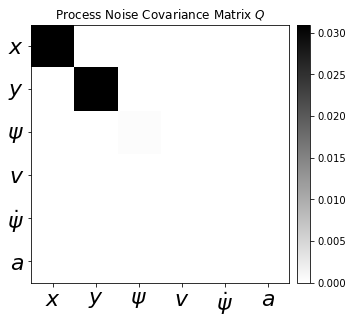

In [209]:
fig = plt.figure(figsize=(5, 5))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Process Noise Covariance Matrix $Q$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(9))
# set the locations and labels of the yticks
plt.yticks(np.arange(8),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$', '$a$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(9))
# set the locations and labels of the yticks
plt.xticks(np.arange(8),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$', '$a$'), fontsize=22)

plt.xlim([-0.5,5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

## Measurement System

## Measurement Function h

Matrix $J_H$ is the Jacobian of the Measurement function $h$ with respect to the state. Function $h$ can be used to compute the predicted measurement from the predicted state.

If a GPS measurement is available, the following function maps the state to the measurement.

In [210]:
hs = Matrix([[xs],
             [vs],
             [ys]])
hs

⎡x⎤
⎢ ⎥
⎢v⎥
⎢ ⎥
⎣y⎦

In [211]:
JHs=hs.jacobian(state)
JHs

⎡1  0  0⎤
⎢       ⎥
⎢0  0  0⎥
⎢       ⎥
⎣0  1  0⎦

If no GPS measurement is available, simply set the corresponding values in $J_h$ to zero.

## Measurement Noise Covariance $R$

"In practical use, the uncertainty estimates take on the significance of relative weights of state estimates and measurements. So it is not so much important that uncertainty is absolutely correct as it is that it be relatively consistent across all models" - Kelly, A. (1994). A 3D state space formulation of a navigation Kalman filter for autonomous vehicles, (May). Retrieved from http://oai.dtic.mil/oai/oai?verb=getRecord&metadataPrefix=html&identifier=ADA282853

In [212]:
# Measurement Standard Deviations
#msdGPS = 5.0 # Standard Deviation of GPS Measurement
msdGPS = 5.0 # ?

#msdSpeed = 3.0 # Standard Deviation of the speed measurement
msdSpeed = 2.1 # DP(speed)

#msdYawrate = 0.1 # Standard Deviation of the yawrate measurement
msdYawrate = 0.15 # DP(yawrate)

#msdAcc = 1.0 # Standard Deviation of the longitudinal Acceleration
msdAcc = 1.0 # DP(ax)

R = np.diag([msdSpeed**2, msdYawrate**2])

print(R, R.shape)

[[4.41   0.    ]
 [0.     0.0225]] (2, 2)


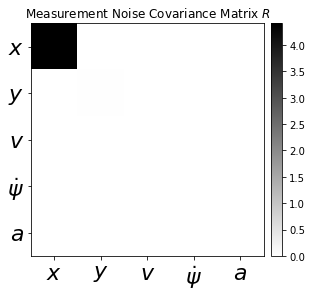

In [213]:
fig = plt.figure(figsize=(4.5, 4.5))
im = plt.imshow(R, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Measurement Noise Covariance Matrix $R$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(6))
# set the locations and labels of the yticks
plt.yticks(np.arange(5),('$x$', '$y$', '$v$', '$\dot \psi$', '$a$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(6))
# set the locations and labels of the yticks
plt.xticks(np.arange(5),('$x$', '$y$', '$v$', '$\dot \psi$', '$a$'), fontsize=22)

plt.xlim([-0.5,4.5])
plt.ylim([4.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

## Identity Matrix

In [214]:
I = np.eye(numstates)
print(I, I.shape)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] (3, 3)


## Loading real measurements

In [215]:
# Updated by Giovanni Santos
# Necessary to avoid error: strptime() argument 0 must be str, not <class 'bytes'>
#def convert_date(date_bytes):
#    return mdates.strpdate2num('%y%m%d')(date_bytes.decode('ascii'))

#def convert_time(date_bytes):
#    return mdates.strpdate2num('%H%M%S%f')(date_bytes.decode('ascii'))


#path = './../RaspberryPi-CarPC/TinkerDataLogger/DataLogs/2014/'
datafile = '2021-01-02-001-Data.csv'

time, \
ax, \
yawrate, \
speed, \
course, \
latitude, \
longitude, \
altitude, \
latitudeGT, \
longitudeGT, \
altitudeGT = np.loadtxt(datafile, delimiter=',', unpack=True, skiprows=1)

print('Read \'%s\' successfully.' % datafile)

Read '2021-01-02-001-Data.csv' successfully.


## Measurement Units

**Lat/Lon** in decimal degree (from GPS)
**Speed** in km/h (from GPS)
**Course** in decimal degree (from GPS)
**Roll/Pitch/Yaw** in decimal degree (from IMU)
**Roll-/Pitch-/Yawrate** in degrees/second (from IMU)
**Accleration** in m/s² (from IMU)

## Approx. Lat/Lon to Meters to check Location

In [216]:
RadiusEarth = 6378388.0 # m
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/°
arcGT= 2.0*np.pi*(RadiusEarth+altitudeGT)/360.0 # m/°

# Equirectangular projection (https://en.wikipedia.org/wiki/Equirectangular_projection)
# x = r * cos(latitude)*(longitude_{K} - longitude_{K-1})
# y = r * (latitude_{K} - latitude_{K-1})
dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m
dxGT = arc * np.cos(latitudeGT*np.pi/180.0) * np.hstack((0.0, np.diff(longitudeGT))) # in m
dyGT = arc * np.hstack((0.0, np.diff(latitudeGT))) # in m

mx = np.cumsum(dx)
my = np.cumsum(dy)
mxGT = np.cumsum(dxGT)
myGT = np.cumsum(dyGT)

ds = np.sqrt(dx**2+dy**2)

GPS=(ds!=0.0).astype('bool') # GPS Trigger for Kalman Filter

## Initial State

[[0.00000000e+00]
 [0.00000000e+00]
 [1.24865486e+00]
 [5.70705205e+00]
 [2.80054200e-03]
 [9.15310812e-01]] (6, 1)


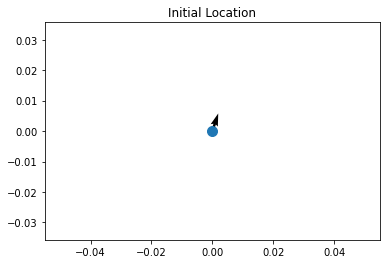

In [217]:
# Convert course from degrees to radians, yawrate from degrees/s to radians/s, and speed from km/h to m/s
x = np.matrix([[mx[0], my[0], course[0], speed[0], yawrate[0], ax[0]]]).T
print(x, x.shape)

U=float(np.cos(x[2])*x[3])
V=float(np.sin(x[2])*x[3])

# quiver plots a 2D field of arrows. X, Y define the arrow locations, U, V define the arrow directions.
plt.quiver(x[0], x[1], U, V)
plt.scatter(float(x[0]), float(x[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')

### Put everything together as a measurement vector

In [218]:
measurements = np.vstack((mx, my, speed, yawrate, ax))
# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)

(5, 1377)


In [219]:
# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Pdv =[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kdv= []
dstate=[]

# Extended Kalman Filter

![Extended Kalman Filter Step](ExtendedKalmanFilterAlgorithm.png)

$$x_k= \begin{bmatrix} x \\ y \\ \psi \\ v \\ \dot\psi \\ a \end{bmatrix} = \begin{bmatrix} \text{Position X} \\ \text{Position Y} \\ \text{Heading} \\ \text{Velocity} \\ \text{Yaw Rate} \\ \text{Acceleration} \end{bmatrix} =  \underbrace{\begin{matrix}x[0] \\ x[1] \\ x[2] \\ x[3] \\ x[4] \\ x[5]  \end{matrix}}_{\textrm{Python Nomenclature}}$$

In [220]:
for filterstep in range(m):

    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "System Dynamics"
    if np.abs(yawrate[filterstep])<0.0001: # Driving straight
        x[0] = x[0] + x[3]*dt * np.cos(x[2]) # Updating position x
        x[1] = x[1] + x[3]*dt * np.sin(x[2]) # Updating position y
        x[2] = x[2] # Updating heading
        x[3] = x[3] + x[5]*dt # Updating velocity
        x[4] = 0.0000001 # avoid numerical issues in Jacobians
        x[5] = x[5] # Updating acceleration
        dstate.append(0)
    else: # otherwise
        x[0] = x[0] + (x[3]/x[4]) * (np.sin(x[4]*dt+x[2]) - np.sin(x[2])) # Updating position x
        x[1] = x[1] + (x[3]/x[4]) * (-np.cos(x[4]*dt+x[2])+ np.cos(x[2])) # Updating position y
        x[2] = (x[2] + x[4]*dt + np.pi) % (2.0*np.pi) - np.pi # Updating heading
        x[3] = x[3] + x[5]*dt # Updating velocity
        x[4] = x[4] # Constant Turn Rate
        x[5] = x[5] # Constant Acceleration
        dstate.append(1)
    
    # Calculate the Jacobian of the process vector function f
    # see "Calculate the Jacobian matrix JF with respect to the state vector"
    a13 = float((x[3]/x[4]) * (np.cos(x[4]*dt+x[2]) - np.cos(x[2])))
    #a14 = float((1.0/x[4]) * (np.sin(x[4]*dt+x[2]) - np.sin(x[2])))
    #a15 = float((dt*x[3]/x[4])*np.cos(x[4]*dt+x[2]) - (x[3]/x[4]**2)*(np.sin(x[4]*dt+x[2]) - np.sin(x[2])))
    a23 = float((x[3]/x[4]) * (np.sin(x[4]*dt+x[2]) - np.sin(x[2])))
    #a24 = float((1.0/x[4]) * (-np.cos(x[4]*dt+x[2]) + np.cos(x[2])))
    #a25 = float((dt*x[3]/x[4])*np.sin(x[4]*dt+x[2]) - (x[3]/x[4]**2)*(-np.cos(x[4]*dt+x[2]) + np.cos(x[2])))
    
    JF = np.matrix([[1.0, 0.0, a13],
                    [0.0, 1.0, a23],
                    [0.0, 0.0, 1.0]])
    
    # Project the error covariance ahead
    P = JF*P*JF.T + Q # !!! ruído não linear J_*Q*J_.T
    
    # Measurement Update (Correction)
    # ===============================
    # Measurement Function
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[3])],
                    [float(x[4])],
                    [float(x[5])]])

    #if GPS[filterstep]: # with 10Hz, every 5th step
    # VERIFIQUE !!!
    JH = np.matrix([[1.0, 0.0],
                    [0.0, 1.0]])
    #else: # every other step
        #JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        #                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        #                [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
        #                [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        #                [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])        
    
    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = measurements[:,filterstep].reshape(JH.shape[0],1)
    y = Z - (hx)                         # Innovation or Residual
    x = x + (K*y)

    # Update the error covariance
    P = (I - (K*JH))*P


    # Save states for Plotting
    x0.append(float(x[0])) # pos x ***
    x1.append(float(x[1])) # pos y ***
    
    x2.append(float(x[2])) # heading
    x3.append(float(x[3])) # velocity
    x4.append(float(x[4])) # yaw-rate
    x5.append(float(x[5])) # acceleration
    
    Zx.append(float(Z[0])) # pos x (GPS) ***
    Zy.append(float(Z[1])) # pos y (GPS) ***
    
    # cov:
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pdv.append(float(P[5,5]))
    # kalman gain
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kdv.append(float(K[5,0]))

ValueError: shapes (2,2) and (3,3) not aligned: 2 (dim 1) != 3 (dim 0)

## Plots

### Uncertainties

In [ ]:
fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),Px, label='$x$')
plt.step(range(m),Py, label='$y$')
plt.step(range(m),Pdx, label='$\psi$')
plt.step(range(m),Pdy, label='$v$')
plt.step(range(m),Pddx, label='$\dot \psi$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})

In [ ]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$ (after %i Filter Steps)' % (m))
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(6))
# set the locations and labels of the yticks
plt.yticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(6))
# set the locations and labels of the yticks
plt.xticks(np.arange(5),('$x$', '$y$', '$\psi$', '$v$', '$\dot \psi$'), fontsize=22)

plt.xlim([-0.5,4.5])
plt.ylim([4.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

### Kalman Gains

In [ ]:
fig = plt.figure(figsize=(16,9))
plt.step(range(len(measurements[0])),Kx, label='$x$')
plt.step(range(len(measurements[0])),Ky, label='$y$')
plt.step(range(len(measurements[0])),Kdx, label='$\psi$')
plt.step(range(len(measurements[0])),Kdy, label='$v$')
plt.step(range(len(measurements[0])),Kddx, label='$\dot \psi$')


plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(prop={'size':18})
plt.ylim([-0.25,0.25]);

## State Vector

In [ ]:
fig = plt.figure(figsize=(16,16))
plt.subplot(511)
plt.step(range(len(measurements[0])),x0-mx[0], label='$x$')
plt.step(range(len(measurements[0])),x1-my[0], label='$y$')

plt.title('Extended Kalman Filter State Estimates (State Vector $x$)')
plt.legend(loc='best')
plt.ylabel('Position (relative to start) [m]')

plt.subplot(512)
plt.step(range(len(measurements[0])),x2, label='$\psi$')
plt.step(range(len(measurements[0])),(course+np.pi)%(2.0*np.pi) - np.pi, label='$\psi$ (from GPS as reference)')
plt.ylabel('Course')
plt.legend(loc='best')
           
plt.subplot(513)
plt.step(range(len(measurements[0])),x3, label='$v$')
plt.step(range(len(measurements[0])),speed, label='$v$ (from GPS as reference)', alpha=0.6)
plt.ylabel('Velocity')
plt.ylim([0, 30])
plt.legend(loc='best')

plt.subplot(514)
plt.step(range(len(measurements[0])),x4, label='$\dot \psi$')
plt.step(range(len(measurements[0])),yawrate, label='$\dot \psi$ (from IMU as reference)', alpha=0.6)
plt.ylabel('Yaw Rate')
plt.ylim([-0.6, 0.6])
plt.legend(loc='best')

plt.subplot(515)
plt.step(range(len(measurements[0])),x5, label='$a$')
plt.step(range(len(measurements[0])),ax, label='$a$ (from IMU as reference)', alpha=0.6)
plt.ylabel('Acceleration')
#plt.ylim([-0.6, 0.6])
plt.legend(loc='best')
plt.xlabel('Filter Step')

plt.savefig('Extended-Kalman-Filter-CTRA-State-Estimates.png', dpi=72, transparent=True, bbox_inches='tight')

## Position x/y

In [ ]:
fig = plt.figure(figsize=(16,9))

# EKF State
plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
plt.plot(x0,x1, label='EKF Position', c='k', lw=5)

# Measurements
#plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', marker='+')
plt.scatter(mx,my, s=50, label='GPS Measurements', marker='+')
#cbar=plt.colorbar(ticks=np.arange(20))
#cbar.ax.set_ylabel(u'EPE', rotation=270)
#cbar.ax.set_xlabel(u'm')

# Ground Truth
#plt.scatter(mxGT[::5],myGT[::5], s=50, label='Ground Truth', marker='o')
plt.scatter(mxGT,myGT, s=50, label='Ground Truth', marker='o')

# Start/Goal
plt.scatter(x0[0],x1[0], s=60, label='Start', c='g')
plt.scatter(x0[-1],x1[-1], s=60, label='Goal', c='r')

plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Position')
plt.legend(loc='best')
plt.axis('equal')
#plt.tight_layout()

#plt.savefig('Extended-Kalman-Filter-CTRA-Position.png', dpi=72, transparent=True, bbox_inches='tight')

### Detailed View

In [ ]:
fig = plt.figure(figsize=(12,9))

plt.subplot(221)
# EKF State
plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

# Measurements
plt.scatter(mx,my, s=50, label='GPS Measurements', alpha=0.5, marker='+')

#cbar=plt.colorbar(ticks=np.arange(20))
#cbar.ax.set_ylabel(u'EPE', rotation=270)
#cbar.ax.set_xlabel(u'm')

# Ground Truth
plt.scatter(mxGT,myGT, s=50, label='Ground Truth', alpha=0.5,marker='o')

plt.xlabel('X [m]')
plt.xlim(90, 160)
plt.ylabel('Y [m]')
plt.ylim(430, 580)
plt.title('Position')
plt.legend(loc='best')


plt.subplot(222)

# EKF State
#plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
plt.plot(x0,x1, label='EKF Position', c='g', lw=5)

# Measurements
plt.scatter(mx,my, s=50, label='GPS Measurements', alpha=0.5, marker='+')
#cbar=plt.colorbar(ticks=np.arange(20))
#cbar.ax.set_ylabel(u'EPE', rotation=270)
#cbar.ax.set_xlabel(u'm')

# Ground Truth
plt.scatter(mxGT,myGT, s=50, label='Ground Truth', alpha=0.5,marker='o')

plt.xlabel('X [m]')
plt.xlim(-80, -30)
plt.ylabel('Y [m]')
plt.ylim(260, 370)
plt.title('Position')
plt.legend(loc='best')

# Gráficos de Erros

In [ ]:
# Erro na medida (Longitude)
ErrxGPS = abs(Zx-mxGT)
stats.describe(ErrxGPS)

In [ ]:
# Erro na estimativa (Longitude)
ErrxEKF = abs(x0-mxGT) 
stats.describe(ErrxEKF)

In [ ]:
fig = plt.figure(figsize=(16,9))
plt.step(range(len(measurements[0])),ErrxGPS, label='$xGPS$')
plt.step(range(len(measurements[0])),ErrxEKF, label='$xEKF$')
#plt.title('')
plt.legend(prop={'size':18})

In [ ]:
# Erro na medida (Latitude)
ErryGPS = abs(Zy-myGT)
stats.describe(ErryGPS)

In [ ]:
# Erro na estimativa (Latitude)
ErryEKF = abs(x1-myGT)
stats.describe(ErryEKF)

In [ ]:
fig = plt.figure(figsize=(16,9))
plt.step(range(len(measurements[0])),ErryGPS, label='$yGPS$')
plt.step(range(len(measurements[0])),ErryEKF, label='$yEKF$')
#plt.title('')
plt.legend(prop={'size':18})

# Acknowledgement

This work is based on https://github.com/balzer82/Kalman/blob/master/Extended-Kalman-Filter-CTRA.ipynb